In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from utils.visualizer import Visualizer
from IPython.display import SVG, display
from sklearn.metrics import precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle
import sklearn
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

In [21]:
import pydot

def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

ImportError: No module named pydot

# Build the dataset

In [ ]:
JPEG_FOLDER = '../data/VOCdevkit/VOC2012/JPEGImages'
ims = []

for fname in os.listdir(JPEG_FOLDER):
    ims.append(plt.imread(os.path.join(JPEG_FOLDER, fname)))

In [ ]:
import scipy as sp

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def crop(img):    
    img = rgb2gray(img)
    
    if img.shape[0] > img.shape[1]:
        img = sp.ndimage.rotate(img, 90)
        
    return sp.misc.imresize(img, [350, 500])

In [ ]:
base = np.asarray(map(crop, ims))

In [ ]:
with open('../data/mnist.pkl') as f:
    dataset = pickle.load(f)

In [ ]:
train = dataset[0][0].reshape(-1, 28, 28)
val = dataset[1][0].reshape(-1, 28, 28)
test = dataset[2][0].reshape(-1, 28, 28)

In [ ]:
i = X_y[1][0].reshape(350, 500)
plt.imshow(i, cmap=plt.cm.Greys_r)
plt.imsave('../im1.png', i, cmap=plt.cm.Greys_r)

In [ ]:
digits = (np.vstack([train, val, test]) * 255).astype(np.uint8)

In [ ]:
train_labels = dataset[0][1]
val_labels = dataset[1][1]
test_labels = dataset[2][1]

In [ ]:
labels = np.hstack([train_labels, val_labels, test_labels])

In [ ]:
import itertools

cells = list(itertools.product(range(350 / 40), range(500 / 40)))

In [ ]:
def add_digits(img, digits, labels, target, size):
    pad_idxs = np.random.choice(range(len(cells)), size=size, replace=False)
    tmp = img.copy()
    answer = np.zeros_like(img)

    for i in range(size):
        x, y = np.array(cells[pad_idxs[i]]) * 40
        digit_idx = np.random.choice(digits.shape[0])
        label = labels[digit_idx]
        tmp2 = sp.ndimage.rotate(digits[digit_idx], np.random.randint(360))
        tmp2[tmp2 <= 0.5 * 255] = 0
        tmp2[tmp2 > 0.5 * 255] = 255

        tmp2[tmp2 >= 255*0.5] = 255
        tmp2[tmp2 < 255*0.5] = 0

        blured = sp.ndimage.gaussian_filter(tmp2, sigma=0.5)

        tmp2 = blured.astype(np.int64) - tmp2.astype(np.int64)

        tmp22 = np.zeros_like(tmp2)

        tmp22[tmp2 >= 0] = (tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean() + 128) % 256
        tmp22[tmp2 < 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean()
        tmp22[tmp2 == 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]][tmp2 == 0]

        tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = tmp22
        
        if label == target:
            answer[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = 1
        
    return tmp, answer
   
size = 10
target = 7
plt.figure(figsize=(10,10))
plt.imshow(add_digits(base[10050], digits, labels, target, size)[0], cmap=plt.cm.Greys_r)
plt.grid('off')

In [ ]:
dataset = []
targets = []
target = 7
size = 10

for img in base:
    new_img, answer = add_digits(img, digits, labels, target, size)
    dataset.append(new_img)
    targets.append(answer)

In [ ]:
dataset = np.asarray(dataset)
targets = np.asarray(targets)

In [4]:
dataset = np.load('../data/artificial_dataset1.npy')
targets = np.load('../data/artificial_dataset1_targets.npy')

In [ ]:
np.save('../data/artificial_dataset1', dataset)

In [ ]:
np.save('../data/artificial_dataset1_targets', targets)

In [5]:
# cascade_builder(input_layer, num_filters, filter_size, pool_size)
# num_filters
# filter_size
# pool_size
#
# Returns: cascade, complaxity
def cascade_builder(input_layer, num_filters, filter_size, pool_size, name):
    cascade0 = lasagne.layers.Conv2DLayer(input_layer,
                                          num_filters=num_filters,
                                          filter_size=filter_size,
                                          nonlinearity=lasagne.nonlinearities.elu,
                                          pad='same',
                                          name='conv_l_' + name)
#     cascade1 = lasagne.layers.Conv2DLayer(cascade0,
#                                           num_filters=num_filters,
#                                           filter_size=filter_size,
#                                           nonlinearity=lasagne.nonlinearities.elu,
#                                           pad='same')
    cascade = lasagne.layers.MaxPool2DLayer(cascade0, pool_size=pool_size, name = 'MaxPool_l_' + name)
    
    complexity = np.prod(cascade0.filter_size) * cascade0.num_filters
    
    return cascade, complexity

In [6]:
from models.buldozer import Buldozer

In [7]:
# params = ((4, 3, 4),
#           (8, 3, 2), 
#           (16, 3, 2),
#           (32, 3, 2),
#           (64, 3, 2))
# buldozer = Buldozer(
#                     [cascade_builder] * 5,
#                     params,
#                     img_shape    = (350, 500),
#                     c_sub_objs   = [1e-0, 0.0, 0.0, 0.0, 0.0],
#                     c_sub_obj_cs = [1e-1, 0.0, 0.0, 0.0, 0.0],
#                     c_complexity=0.0001,
#                     c_obj=1
#                    )

In [7]:
X_y = train_test_split(dataset.reshape(-1, 1, 350, 500), targets.reshape(-1, 1, 350, 500), random_state=42)

In [15]:
params = [[4, 3, 4]]
buldozer = Buldozer(
                    [cascade_builder] * 1,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [1e-0],
                    c_sub_obj_cs = [1e-1],
                    c_complexity=1e-5,
                    c_obj=1e-0,
                    c = 1e-0
                   )

In [18]:
(buldozer.predict(X_y[1][:100]) > 0.5).sum()a

73579

<IPython.core.display.Javascript object>


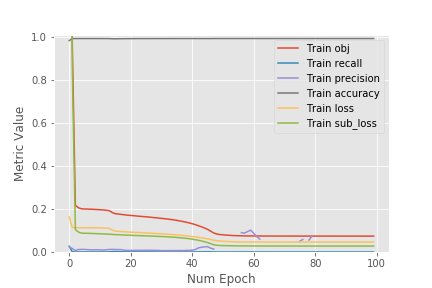

<IPython.core.display.Javascript object>


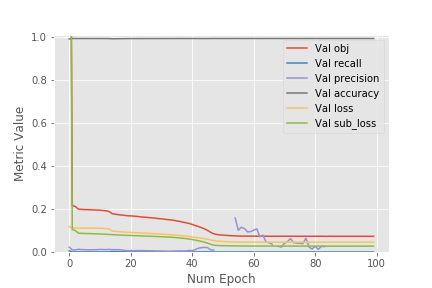

<IPython.core.display.Javascript object>


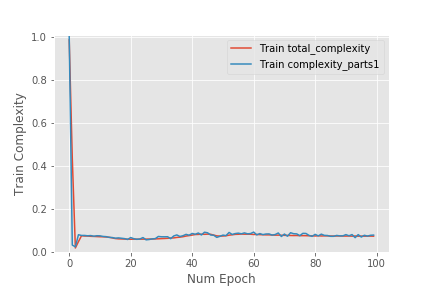

<IPython.core.display.Javascript object>


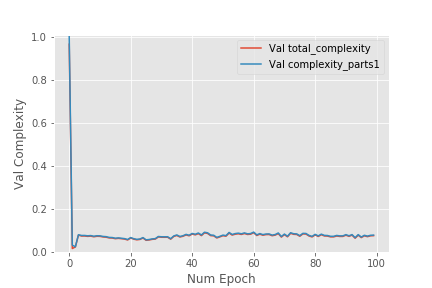

Epoch 1 of 100 took 84.291s
Epoch 2 of 100 took 83.831s
Epoch 3 of 100 took 84.772s
Epoch 4 of 100 took 85.722s
Epoch 5 of 100 took 84.250s
Epoch 6 of 100 took 81.700s
Epoch 7 of 100 took 82.119s
Epoch 8 of 100 took 83.854s
Epoch 9 of 100 took 84.276s
Epoch 10 of 100 took 83.398s
Epoch 11 of 100 took 83.060s
Epoch 12 of 100 took 83.345s
Epoch 13 of 100 took 84.607s
Epoch 14 of 100 took 84.702s
Epoch 15 of 100 took 82.978s
Epoch 16 of 100 took 77.935s
Epoch 17 of 100 took 64.115s
Epoch 18 of 100 took 64.922s
Epoch 19 of 100 took 63.189s
Epoch 20 of 100 took 64.764s
Epoch 21 of 100 took 63.501s
Epoch 22 of 100 took 64.916s
Epoch 23 of 100 took 63.038s
Epoch 24 of 100 took 55.864s
Epoch 25 of 100 took 57.304s
Epoch 26 of 100 took 59.299s
Epoch 27 of 100 took 62.043s
Epoch 28 of 100 took 59.794s
Epoch 29 of 100 took 55.286s
Epoch 30 of 100 took 55.891s
Epoch 31 of 100 took 58.239s
Epoch 32 of 100 took 61.148s
Epoch 33 of 100 took 57.193s
Epoch 34 of 100 took 55.524s
Epoch 35 of 100 took 58

In [19]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy', 
               'loss', 
               'sub_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=150
)

In [ ]:
buldozer.save('../weights', 'buldozer_pre_1')

In [ ]:
params = ((4, 3, 4),
          (8, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 2,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 1e-1],
                    c_complexity=0.0001,
                    c_obj=1.0,
                    c=1e-1
                   )

In [ ]:
with np.load(os.path.join('../weights', 'buldozer_pre_1' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [ ]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[3], param_values[:4])

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy', 
               'loss', 
               'sub_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=200, batch_size=150
)

In [ ]:
buldozer.save('../weights', 'buldozer_pre_2')

In [ ]:
with np.load(os.path.join('../weights', 'buldozer_pre_2' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [ ]:
params = ((4, 3, 4),
          (8, 3, 2), 
          (16, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 3,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 0.0, 1e-1],
                    c_complexity=0.0001,
                    c_obj=1.0,
                    c=1e-1
                   )

In [ ]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[9], param_values[:-2])

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy', 
               'loss', 
               'sub_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=400, batch_size=100
)

In [ ]:
buldozer.save('../weights', 'buldozer_pre_3')

In [ ]:
buldozer.evaluate(X_y[1][:100], X_y[-1][:100])

In [ ]:
buldozer.save('../weights/', 'buldozer_pre_1')

In [ ]:
buldozer.save('../weights/', 'buldozer_pre_2')

In [ ]:
buldozer.save('../weights', 'buldozer_pre_3')

In [ ]:
import theano

get_targets = [theano.function([buldozer.targets],
                               lasagne.layers.get_output(buldozer.target_pool_layers[i])) 
               for i in range(len(buldozer.target_pool_layers))]
companions =  [theano.function([buldozer.input_X],
                               lasagne.layers.get_output(buldozer.downsampled_activation_layers[i]))
                               for i in range(len(buldozer.downsampled_activation_layers))]

def draw_precision_recall(prediction, target):
    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc='best')
    plt.show()
    
    for r in [0.90, 0.95, 0.99, 0.999]:
        print 'Recall:', recall[np.max(np.where(recall >= r))]
        print 'Precision:', precision[np.max(np.where(recall >= r))]
        print

In [ ]:
%matplotlib inline

prediction = companions[0](X_y[1][:100]).ravel()
target = get_targets[0](X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

In [ ]:
%matplotlib inline

prediction = companions[1](X_y[1][:100]).ravel()
target = get_targets[1](X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

In [ ]:
%matplotlib inline

prediction = companions[2](X_y[1][:100]).ravel()
target = get_targets[2](X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

In [ ]:
%matplotlib inline

prediction = companions[2](X_y[1][:100]).ravel()
target = get_targets[2](X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

In [ ]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

In [ ]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

In [ ]:
X_y[1][:100].shape

In [ ]:
X_y[-1][:100].shape

In [ ]:
print 1